## Otimizando portfolios usando Pymoo

### Exemplo: Alocação de Portfolio

#### O problema consiste em alocar um determinado percentual de um capital C em um conjunto de n possíveis ativos financeiros de risco de modo a maximizar  a relação Retorno_ajustado/Risco.

#### Retorno ajustado= Retorno esperado do portfolio - retorno do ativo livre de risco 
#### Risco é medido como a variância dos retornos

### Este exemplo de alocação de portfolio financeiro é baseado na Teoria de Portfólio  Markowitz (Mean-Variance Portfolio Theory)  e assim tem como base o cálculo de retornos e covariâncias destes retornos. 

##### Note: This problem can be solved directly using a quadratic solver (which will be much more efficient). However, such a solver finds only a single solution and must run multiple times to approximate the Pareto-optimal front. Moreover, it is worth noting that if we slightly change the problem to cubic or non-polynomial, it can not be applied anymore. The method shown provides more flexibility, for instance, optimizing objectives derived from Monte-Carlo sampling.

In [ ]:
# Instalar biblioteca pymoo: Multi-objective Optimization in Python - https://pymoo.org/
# Caso não instalado previamente, rode o comando abaixo
# !pip install pymoo

In [1]:
# importando classes necessárias
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.util.remote import Remote

from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.operators.sampling.rnd import FloatRandomSampling,IntegerRandomSampling
from pymoo.operators.repair.rounding import RoundingRepair

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [15]:
#file = Remote.get_instance().load("examples", "portfolio_allocation.csv", to=None)
#df = pd.read_csv(file, parse_dates=True, index_col="date")
df = pd.read_csv("portfolio_allocation.csv", parse_dates=True, index_col="date")

In [16]:
df

,HON,VRTX,PLD,DUK,GS,GOOGL,AVGO,MS,AMD,JPM,...,T,MA,CSX,MDT,ELV,TMO,KMB,OXY,EQIX,DHR
date,,,,,,,,,,,,,,,,,,,,,
2020-12-10,181.507,224.04,92.3451,84.9324,234.004,88.0633,37.0062,60.7993,91.66,113.727,...,20.1955,327.977,29.3045,107.420,306.763,466.551,125.052,21.1033,664.185,221.736
2020-12-11,183.770,224.17,92.5264,84.7284,229.800,88.4195,36.6251,59.7416,91.65,113.069,...,20.4070,323.930,29.4442,107.125,304.470,469.197,126.864,20.6877,665.999,222.275
2020-12-14,181.404,228.13,92.0502,84.3493,227.683,87.2966,37.1640,58.3838,94.78,111.861,...,20.1040,327.608,28.9529,106.731,303.190,465.163,126.864,18.9838,667.123,219.630
2020-12-15,183.391,228.81,94.5962,85.2572,232.122,87.7359,37.7290,60.3372,97.12,113.777,...,20.1238,330.080,29.3748,109.536,306.237,469.007,126.698,19.6479,672.546,221.696
2020-12-16,180.080,232.11,94.8814,83.8683,233.415,87.5422,38.3450,60.6011,96.85,114.120,...,19.9328,328.556,29.0113,109.616,303.329,455.868,126.874,19.2612,667.281,220.428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-18,191.450,435.52,123.8000,123.8000,776.300,284.2800,340.5000,159.8300,230.29,299.410,...,25.6000,527.580,33.9900,100.800,324.530,576.030,103.250,42.5200,779.170,225.510
2025-11-19,190.570,421.03,122.4000,122.2300,785.990,292.8100,354.4200,162.2900,223.55,303.270,...,25.2700,530.360,33.9600,100.340,316.370,573.790,102.370,41.4500,765.080,222.410
2025-11-20,188.140,422.32,123.1200,122.5400,773.700,289.4500,346.8200,158.7000,206.02,298.380,...,25.5200,527.880,33.6800,99.350,313.990,572.740,103.760,41.2100,752.810,222.180


In [ ]:
#df.to_csv("portfolio_allocation.csv")

In [5]:
returns = df.pct_change().dropna(how="all")# calcula os retornos (pct_change) para todas as colunas, exceto NaN
print('Shapes of returns=',returns.shape)
mu = (1 + returns).prod() ** (252 / returns.count()) - 1 # retorno medio anuais (252 dias)
cov = returns.cov() * 252 # calcula a matriz de covariancia dos retornos

mu, cov = mu.to_numpy(), cov.to_numpy()
print('Shapes of mu=',mu.shape,' and cov=',cov.shape)
labels = df.columns
print(len(labels),' Assets=',list(labels))



Shapes of returns= (1244, 80)
Shapes of mu= (80,)  and cov= (80, 80)
80  Assets= ['HCA', 'UPS', 'CAT', 'INTC', 'V', 'PM', 'AMD', 'CRM', 'C', 'EOG', 'AVGO', 'LOW', 'COST', 'ACN', 'CL', 'WMT', 'NSC', 'ADI', 'NVDA', 'PANW', 'AXP', 'BKNG', 'TSLA', 'XOM', 'GS', 'INTU', 'BLK', 'BMY', 'AAPL', 'BAC', 'SO', 'OXY', 'TGT', 'COP', 'MS', 'GOOG', 'MO', 'NOW', 'TXN', 'CSX', 'ADP', 'LRCX', 'RTX', 'TMO', 'ELV', 'USB', 'DHR', 'REGN', 'CB', 'ISRG', 'MCD', 'AMZN', 'ADBE', 'CVX', 'LIN', 'GOOGL', 'CSCO', 'EQIX', 'ABBV', 'PLD', 'PFE', 'ABNB', 'MDLZ', 'ABT', 'MSFT', 'NKE', 'LMT', 'LLY', 'META', 'HON', 'CCI', 'MU', 'SPGI', 'PG', 'JPM', 'AMAT', 'DIS', 'HD', 'QCOM', 'PEP']


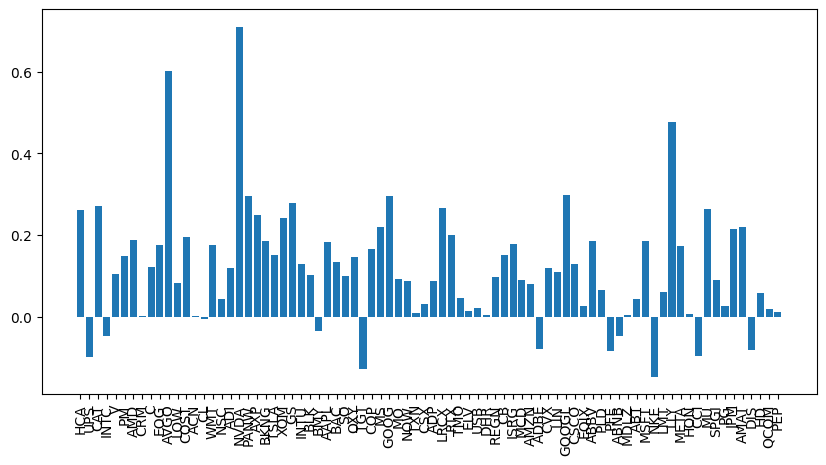

In [6]:
# Retorno medio por ativo
fig, ax = plt.subplots(figsize=(10, 5))
k = np.arange(len(mu))
ax.bar(k, mu)
ax.set_xticks(k, labels, rotation = 90)
plt.show()

DONE


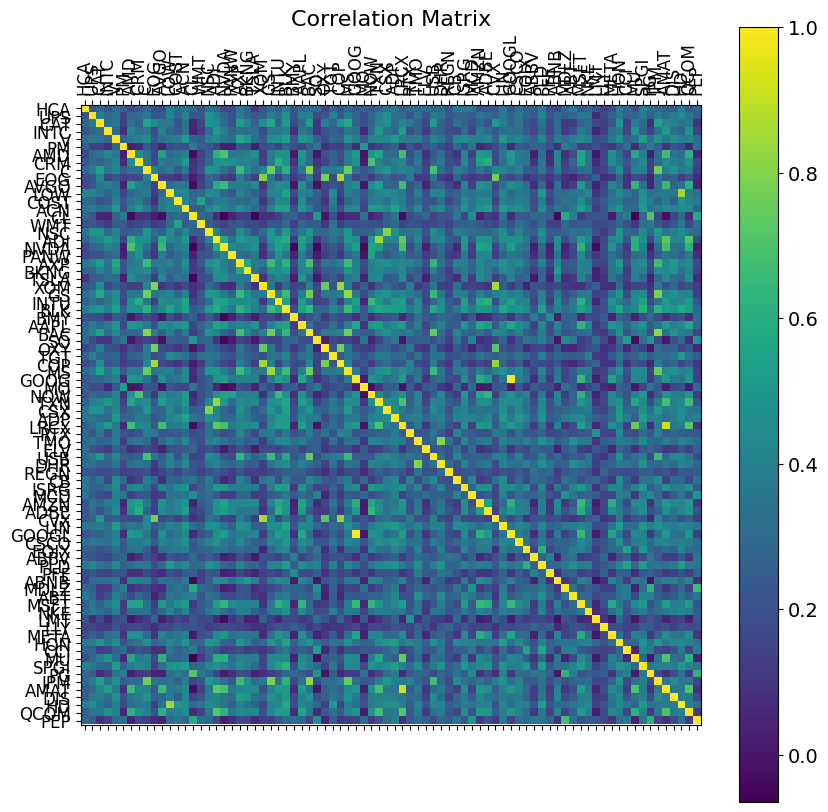

In [7]:
# Matriz de Correlação de Retornos
f = plt.figure(figsize=(10, 10))
plt.matshow(returns.corr(), fignum=f.number)
plt.xticks(k, labels, fontsize=12, rotation=90)
plt.yticks(k, labels, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
print("DONE")

# Descrição do Problema de Otimização

# Otimização de Portfólios utilizando Algoritmos Genéticos

In [8]:
from pymoo.core.problem import ElementwiseProblem

class PortfolioProblemGA(ElementwiseProblem):
    def __init__(self, mu, cov, risk_free_rate=0.02, **kwargs):
        # Problema com apenas 1 objetivo. Minimizar a função objetivo _evaluate que é sharpe * -1
        super().__init__(n_var=len(df.columns), n_obj=1, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
        self.risk_free_rate = risk_free_rate

    def _evaluate(self, x, out, *args, **kwargs):
        exp_return = x @ self.mu # @ é multiplicação de matriz 
        exp_risk = np.sqrt(x.T @ self.cov @ x) 
        sharpe = (exp_return - self.risk_free_rate) / exp_risk

        out["F"] = -sharpe #[exp_risk, -exp_return]
        # importante : Note o sinal negativo para Sharpe (queremos maximizar Sharpe), mas o pymoo esperar minimizar
        # 
        out["risk_return"] = [exp_risk, -exp_return]

In [9]:
from pymoo.core.repair import Repair

class PortfolioRepair(Repair): # Elimina pesos muito baixos (menores que 0.001)
    def _do(self, problem, X, **kwargs):
        X[X < 1e-3] = 0 # Seta valores menores que 0.001 (1e-3) para zero
        X=X / X.sum(axis=1, keepdims=True) # normaliza o portfolio (somatorio dos pesos igual a 1) 
        return X

In [10]:
# Solução com GA
problem = PortfolioProblemGA(mu, cov)


algorithm = GA(
    pop_size=100,
    crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=PortfolioRepair()), # Simulated Binary Crossover, hyperparameters: prob of crossover, eta - parameter of crossover distribution
    mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=PortfolioRepair()),  
    eliminate_duplicates=True)

res = minimize(problem, # observe que estamos minimizando
               algorithm,
               termination=('n_gen', 1000),# Criterio de termino: numero de geracoes!
               seed=1,
               verbose=False)

[None]


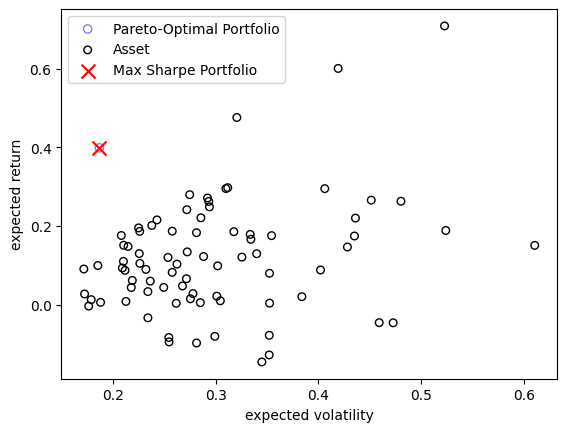

Allocation With Best Sharpe
LLY   = 0.29425
AVGO  = 0.16142
XOM   = 0.15832
NVDA  = 0.09462
WMT   = 0.08795
HCA   = 0.07915
PM    = 0.07590
ABBV  = 0.04839
UPS   = 0.00000
CAT   = 0.00000
INTC  = 0.00000
V     = 0.00000
AMD   = 0.00000
CRM   = 0.00000
C     = 0.00000
EOG   = 0.00000
LOW   = 0.00000
COST  = 0.00000
ACN   = 0.00000
CL    = 0.00000
NSC   = 0.00000
ADI   = 0.00000
PANW  = 0.00000
AXP   = 0.00000
BKNG  = 0.00000
TSLA  = 0.00000
GS    = 0.00000
INTU  = 0.00000
BLK   = 0.00000
BMY   = 0.00000
AAPL  = 0.00000
BAC   = 0.00000
SO    = 0.00000
OXY   = 0.00000
TGT   = 0.00000
COP   = 0.00000
MS    = 0.00000
GOOG  = 0.00000
MO    = 0.00000
NOW   = 0.00000
TXN   = 0.00000
CSX   = 0.00000
ADP   = 0.00000
LRCX  = 0.00000
RTX   = 0.00000
TMO   = 0.00000
ELV   = 0.00000
USB   = 0.00000
DHR   = 0.00000
REGN  = 0.00000
CB    = 0.00000
ISRG  = 0.00000
MCD   = 0.00000
AMZN  = 0.00000
ADBE  = 0.00000
CVX   = 0.00000
LIN   = 0.00000
GOOGL = 0.00000
CSCO  = 0.00000
EQIX  = 0.00000
PLD   = 0.00

In [14]:
# Apresentação dos Resultados
#res.X: Design space values are
#res.F: Objective spaces values

X, F, sharpe = res.opt.get("X", "risk_return", "sharpe")
F = F * [1, -1]
max_sharpe = sharpe.argmax()

plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Pareto-Optimal Portfolio")
plt.scatter(cov.diagonal() ** 0.5, mu, facecolor="none", edgecolors="black", s=30, label="Asset")
plt.scatter(F[max_sharpe, 0], F[max_sharpe, 1], marker="x", s=100, color="red", label="Max Sharpe Portfolio")
plt.legend()
plt.xlabel("expected volatility")
plt.ylabel("expected return")
plt.show()

import operator

allocation = {name: w for name, w in zip(df.columns, X[max_sharpe])}
allocation = sorted(allocation.items(), key=operator.itemgetter(1), reverse=True)

print("Allocation With Best Sharpe")
for name, w in allocation:
    print(f"{name:<5} = {w:.5f}")

## Otimizacao usando algoritmo SMS-EMOA: Evolutionary multiobjective optimization algorithms  based on dominated hypervolume¶
### Problema com dois objetivos simultaneos (multiobjective optimization problem) minimizar risk and return*-1

In [11]:
from pymoo.core.problem import ElementwiseProblem

class PortfolioProblem(ElementwiseProblem):

    def __init__(self, mu, cov, risk_free_rate=0.02, **kwargs):
        # n_var é o numero de variáveis alvo(no caso número de ativos)
        # n_obj problema tem dois objetivos simultaneos de mimizacao: [exp_risk, -exp_return]
        super().__init__(n_var=len(df.columns), n_obj=2, xl=0.0, xu=1.0, **kwargs) 
        self.mu = mu
        self.cov = cov
        self.risk_free_rate = risk_free_rate
# [0.6 , 0.4, 0...0] * [ r1, r2, r3.,.....r4]=
# 0.6*r1+0.4*r2
    def _evaluate(self, x, out, *args, **kwargs): # x é um individuo = alocaçao!!
        exp_return = x @ self.mu # @ é multiplicação de matriz   
        exp_risk = np.sqrt(x.T @ self.cov @ x)  # x.T é a transposta de X
        sharpe = (exp_return - self.risk_free_rate) / exp_risk

        out["F"] = [exp_risk, -exp_return]
        out["sharpe"] = sharpe

        

In [12]:

from pymoo.core.repair import Repair

class PortfolioRepair(Repair): # Elimina pesos muito baixos (menores que 0.001) e normaliza - igual ao caso com GA
    def _do(self, problem, X, **kwargs): 
        X[X < 1e-3] = 0 # Seta valores menores que 0.001 (1e-3) para zero
        X=X / X.sum(axis=1, keepdims=True) # normaliza o portfolio (somatorio dos pesos igual a 1) 
        return X

In [13]:

from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.optimize import minimize

problem = PortfolioProblem(mu, cov)

algorithm = SMSEMOA(repair=PortfolioRepair())

res = minimize(problem,
               algorithm,
               seed=1,
               verbose=False)

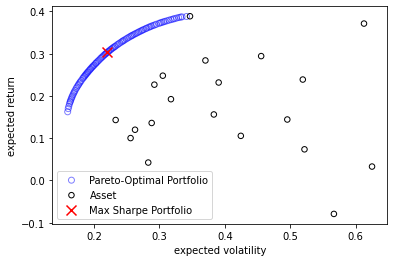

Allocation With Best Sharpe
MA    = 0.34368
FB    = 0.20837
PFE   = 0.20750
BABA  = 0.07315
AAPL  = 0.06464
GOOG  = 0.04575
AMZN  = 0.03935
BBY   = 0.01756
GE    = 0.00000
AMD   = 0.00000
WMT   = 0.00000
BAC   = 0.00000
GM    = 0.00000
T     = 0.00000
UAA   = 0.00000
SHLD  = 0.00000
XOM   = 0.00000
RRC   = 0.00000
JPM   = 0.00000
SBUX  = 0.00000


In [14]:
# Apresentação dos Resultados
X, F, sharpe = res.opt.get("X", "F", "sharpe") # o SMSEMOA retorna em F a fronteira de pareto 
F = F * [1, -1] # F=[exp_risk, -exp_return] *[1,-1]=[exp_risk, exp_return]
max_sharpe = sharpe.argmax()

plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Pareto-Optimal Portfolio")
plt.scatter(cov.diagonal() ** 0.5, mu, facecolor="none", edgecolors="black", s=30, label="Asset")
plt.scatter(F[max_sharpe, 0], F[max_sharpe, 1], marker="x", s=100, color="red", label="Max Sharpe Portfolio")
plt.legend()
plt.xlabel("expected volatility")
plt.ylabel("expected return")
plt.show()

import operator

allocation = {name: w for name, w in zip(df.columns, X[max_sharpe])}
allocation = sorted(allocation.items(), key=operator.itemgetter(1), reverse=True)

print("Allocation With Best Sharpe")
for name, w in allocation:
    print(f"{name:<5} = {w:.5f}")